# Finding pumps that give locally optimal spectral purity

This notebook showcases a local optimization scheme applied on mode purity for SPDC phenomenon in waveguides. The constraint on mean number of photon pair per pump pulse (gain) and on the center frequency of the pump will be imposed using a penalty method and the constraint on the variance of pump will be imposed using a regularization method.

## Import the libraries 

The library used to generate initial seed, to optimize the spectral purity and to post-process the data are imported.

In [1]:
import jax.numpy as jnp
import jax
import jaxopt
import numpy as np
import scipy

import matplotlib.pyplot as plt

import optimization_SPDC as opt
import optimization_quadratures as opt_quad
import optimization_SPDC_gaussain_pump as opt_gauss
import get_initialization_cond as init


key = jax.random.PRNGKey(0)
#from jax.config import config
#config.update("jax_enable_x64", True)
jax.config.update("jax_enable_x64", True)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


# Case where the pump has a frequency dependant phase

## Set general hyperparameters

Hyperparameters define the frequency range, length of waveguide, group velocities and gain

In [2]:
N = 201
wi = -10
wf = 10
delta_omega = (wf - wi)/N
x = jnp.linspace(wi, wf, N)
vp = 0.1
l = 1
y_N = [0.0001, 0.1, 0.2, 0.5, 1.0, 2.0]

## Define phase matching matrices and initialize the pump

In [3]:
G, H = init.get_constants(vp, l, wi, wf, N = N)
random_seed = 0.1*delta_omega*jax.random.uniform(key, shape=(4*N - 2,))
gaussian_seed = 0.001*delta_omega*jnp.array(list(np.exp(-np.linspace(x[0], x[-1], 2*N - 1)**2/.5)) + list(np.exp(-np.linspace(x[0], x[-1], 2*N - 1)**2/.5)))

## Perform BFGS with penalty method and regularization on pump variance

In [4]:
solver = jaxopt.ScipyMinimize(method="BFGS", fun=opt.problem, maxiter=2000, jit = True)
pump = random_seed.copy()
pumps = []
for j in range(len(y_N)):
    for i in range(10):
        print("run " + str(i))
        print("observables: ", opt.get_observables(pump, N, G, H, l))
        (pump, state) = solver.run(pump, x, G, H, l, y_N[j], 5**i)
    pumps.append(pump.copy())

run 0
observables:  (Array(0.29128919, dtype=float64), Array(14.84103648, dtype=float64))


KeyboardInterrupt: 

If the pump has a constant phase (independant of frequency), we can always multiply it by another phase such that the pump in the new frame of reference is purely real. Multiplication of the pump by a global phase does not change the value of the gain or of the Schmidt number.

# Quadratures

In [ ]:
N = 201
wi = -10
wf = 10
omega = np.linspace(wi, wf, N)
delta_omega = np.abs(omega[1] - omega[0])
vp = 0.1
l = 1
Np = 0.01
G, H = init.get_constants(vp, l, wi, wf, Np, N = N)
delta_k = 1.j*G
y_N = 1.
opt_quad.get_observables(gaussian_seed, N, delta_k, l)

(Array(0.01947283, dtype=float64), Array(1.21603413, dtype=float64))

In [ ]:
solver = jaxopt.ScipyMinimize(method="BFGS", fun=opt_quad.problem, maxiter=5000, jit = False)

In [ ]:
# Try reducing the penalty term
pump = random_seed.copy()
pumps_quad = []
for j in range(len(y_N)):
    for i in range(5):
        print("run " + str(i))
        print("observables: ", opt_quad.get_observables(pump, N, delta_k, l))
        (pump, state) = solver.run(pump, omega, delta_k, l, y_N[j], 5**i)
    pumps_quad.append(pump.copy())

run 0
observables:  (Array(0.13250503, dtype=float64), Array(15.58651777, dtype=float64))
BFGS:  0
observables:  (Array(1.02274813, dtype=float64), Array(1.14208508, dtype=float64))
BFGS:  1
observables:  (Array(1.02274813, dtype=float64), Array(1.14208508, dtype=float64))
BFGS:  2
observables:  (Array(1.02274813, dtype=float64), Array(1.14208508, dtype=float64))
run 1
observables:  (Array(1.02274813, dtype=float64), Array(1.14208508, dtype=float64))
BFGS:  0
observables:  (Array(1.00460954, dtype=float64), Array(1.14292455, dtype=float64))
BFGS:  1
observables:  (Array(1.00460954, dtype=float64), Array(1.14292455, dtype=float64))
BFGS:  2
observables:  (Array(1.00460954, dtype=float64), Array(1.14292455, dtype=float64))
run 2
observables:  (Array(1.00460954, dtype=float64), Array(1.14292455, dtype=float64))
BFGS:  0
observables:  (Array(1.00242965, dtype=float64), Array(1.14302504, dtype=float64))
BFGS:  1
observables:  (Array(1.00072715, dtype=float64), Array(1.14310396, dtype=float6

## Optimization of a Gaussian

Now, assuming the optimal pump is truly Gaussian and a real function, only 2 parameters are needed, which are the amplitude and the width of the Gaussian. 

In [4]:
gaussian_amplitude = 2*np.random.random()*delta_omega
gaussian_width = 4*delta_omega
params = [gaussian_amplitude, gaussian_width]
gauss_solver = jaxopt.ScipyMinimize(method = "BFGS", fun=opt_gauss.problem, maxiter=20, jit= False)
theta = params.copy()
thetas = []
for j in range(len(y_N)):
    for i in range(10):
        print("run number " + str(i))
        print("Schmidt number : " + str(opt_gauss.get_observables(theta, x, 1.j*G, l)[1]))
        (theta, state) = gauss_solver.run(theta, x, 1.j*G, l, y_N[j], 3**i)
    thetas.append(theta.copy())

run number 0


Comparing the likelihood between the optimal Gaussian pump and optimal pump from pseudo-quadrature, we see they are very similar

In [ ]:
for i in range(len(y_N)):
    gauss = opt_gauss.get_gaussian(thetas[i], x)
    print("difference for gain of " + str(y_N[i]) + " is: " + str((pumps_quad[i] - gauss)@(pumps_quad[i] - gauss)/gauss@gauss))

This result is interesting, because for low gain ($n \ll 1$), it has been proven analytically through perturbative regime that to obtain purely separable joint spectral amplitude, a Gaussian phase matching function and a Gaussian pump are needed (Quesada and Branczyk, 2018). A numerical optimization scheme was performed with an objective function stemming from low-gain regime, which is a restricted case of the general SPDC in waveguides. Let us compare how does the optimal pump obtained theorically fare in high gain regime with the Gaussian pumps obtained with optimization at high gain.

# Comparing low gain optimal pump at high gain with optimized pump at this high gain

A main difference between the low-gain regime and high gain regime is the presence of higher photon number state terms in the output state. In low-gain regime, the optimal pump can be found analytically to be a Gaussian of a specific width. Here we show how the Schmidt number given by the optimal pump is compared to the Schmidt number given by the low-gain optimal pump scaled to give a specific gain.

In [ ]:
ratio = 1.61/1.13
vi = vp / (1 - 2 * ratio * vp / l)
vs = vp / (1 + 2 * ratio * vp / l)
width = jnp.sqrt(ratio/(2*l*(1/vp - 1/vi)))
theta = [0.1*delta_omega, width]
low_pump = opt_gauss.get_gaussian(theta, x)

In [ ]:
amps = [0.0072305, 0.22415, 0.311079, 0.46748, 0.61615, 0.78247]
schmidt_numbers_low = []
schmidt_numbers = []
for i, amp in enumerate(amps):
    diff_theta = [amp*delta_omega, width]
    schmidt_numbers_low.append(opt_gauss.get_observables(diff_theta, x, 1.j*G, l)[1])
    schmidt_numbers.append(opt_gauss.get_observables(list(jnp.array(thetas[i])), x, 1.j*G, l)[1])

Now, we can compare them by plotting the Schmidt number as function of mean number of photon pairs per pulse

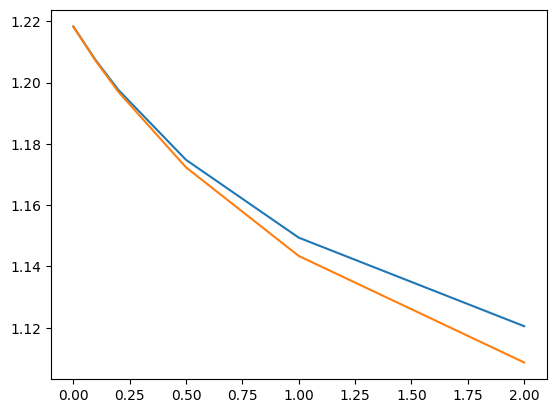

In [ ]:
plt.plot(y_N, schmidt_numbers_low)
plt.plot(y_N, schmidt_numbers)

Comparing the Schmidt number, we see that the pump optimized for low gain does not seem to be optimal for high gain.